In [4]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression


def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Прочитаем базу нефть-brent-2010-2019.csv

In [7]:
duq = pd.read_csv('нефть-brent-2010-2019.csv')
duq['date']=pd.to_datetime(duq['date'])
duq.head()

,date,value
0,2019-09-01,58.84
1,2019-08-30,59.19
2,2019-08-29,60.37
3,2019-08-28,59.84
4,2019-08-27,59.59


Сделаем парсинг по дате:

In [9]:
duq['date_time'] = duq["date"].apply( lambda duq : 
datetime.datetime(year=duq.year, month=duq.month, day=duq.day))
duq.set_index(duq["date_time"],inplace=True)
duq.head()

,date,value,date_time
date_time,,,
2019-09-01,2019-09-01,58.84,2019-09-01
2019-08-30,2019-08-30,59.19,2019-08-30
2019-08-29,2019-08-29,60.37,2019-08-29
2019-08-28,2019-08-28,59.84,2019-08-28
2019-08-27,2019-08-27,59.59,2019-08-27


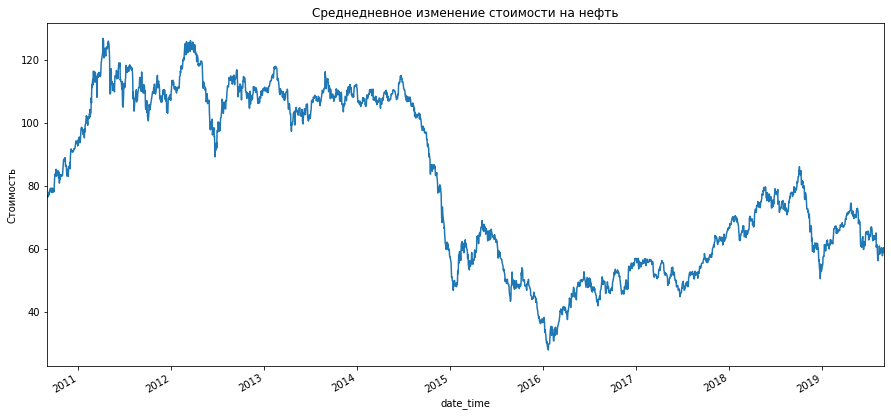

In [10]:
plt.figure(figsize(15,7))
duq['value'].plot()
plt.title('Cреднедневное изменение стоимости на нефть')
plt.ylabel ('Стоимость');
pylab.show()

In [11]:
def code_mean(duq, cat_feature, real_feature):
    return dict(duq.groupby(cat_feature)[real_feature].mean())

In [12]:
duq["weekday"] = duq.index.weekday
duq['is_weekend'] = duq.weekday.isin([5,6])*1
duq.head()

,date,value,date_time,weekday,is_weekend
date_time,,,,,
2019-09-01,2019-09-01,58.84,2019-09-01,6,1
2019-08-30,2019-08-30,59.19,2019-08-30,4,0
2019-08-29,2019-08-29,60.37,2019-08-29,3,0
2019-08-28,2019-08-28,59.84,2019-08-28,2,0
2019-08-27,2019-08-27,59.59,2019-08-27,1,0


In [18]:
def prepareData(duq, lag_start=5, lag_end=20, test_size=0.15):
    duq = pd.DataFrame(duq.copy())
    duq.columns = ["y"]
    
    test_index = int(len(duq)*(1-test_size))
   
    for i in range(lag_start, lag_end):
        duq["lag_{}".format(i)] = duq.y.shift(i)

    duq["weekday"] = duq.index.weekday
    duq['is_weekend'] = duq.weekday.isin([5,6])*1

    
    duq['weekday_average'] = list(map(code_mean(duq[:test_index], 'weekday', "y").get, duq.weekday))

    duq.drop(["weekday"], axis=1, inplace=True)

    duq = duq.dropna()
    duq = duq.reset_index(drop=True)
 

разбиваем весь датасет на тренировочную и тестовую выборку

In [19]:
X_train = duq.loc[:test_index].drop(["y"], axis=1)
    y_train = duq.loc[:test_index]["y"]
    X_test = duq.loc[test_index:].drop(["y"], axis=1)
    y_test = duq.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

IndentationError: unexpected indent (<ipython-input-19-8d3e01816286>, line 2)

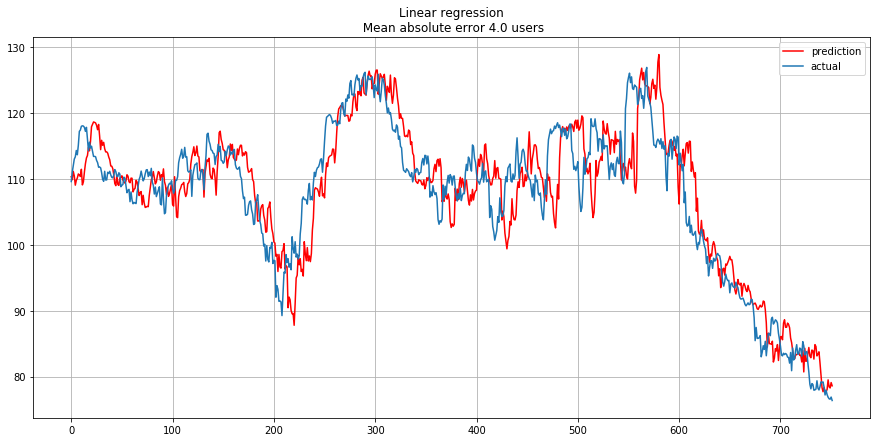

In [16]:
X_train, X_test, y_train, y_test = prepareData(duq['value'], test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

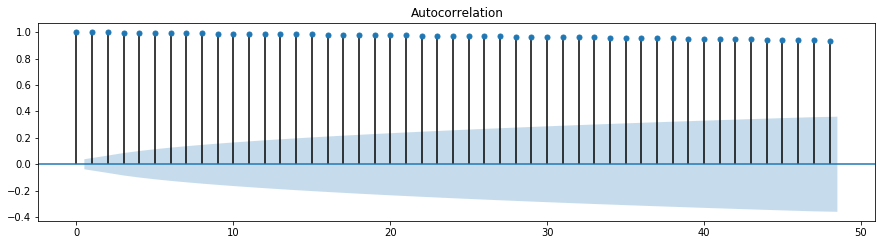

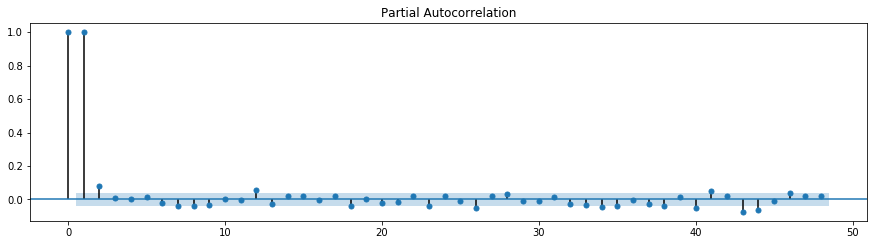

In [17]:

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(duq['value'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(duq['value'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

**Вывод:** Мы использовали линейную рересию для предсказания цены на нефть в течении нескольких лет.

После регрессии `Частичная автокорреляция` дала лучший результат.